In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

sys.path.append("../functions")

from Utility import *
from Plotting import *

%matplotlib inline
%load_ext jupyter_black

plt.style.use("../matplotlib_style.txt")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Reading Data


In [3]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

## Low meta and high meta agents


In [7]:
high_syn_df = lv_induction_data.copy()
high_syn_df["cj"] = np.where(high_syn_df["cor"] == 1, 5, 1)
low_syn_df = lv_induction_data.copy()
low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
human_qsr = (
    lv_induction_data.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)

Statistics=25.0, p=6.498805474855473e-10
Statistics=0.0, p=1.6256984569330967e-10
Statistics=0.0, p=1.6256984569330967e-10


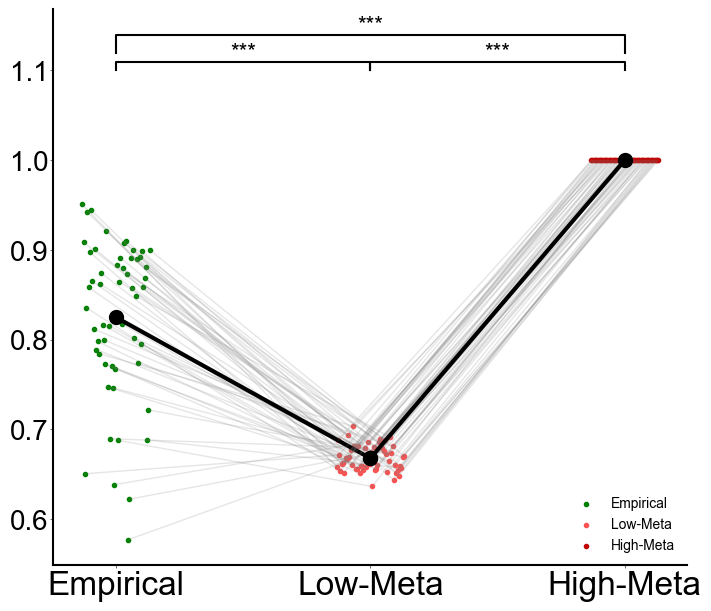

In [15]:
groups = ["Empirical", "Low-Meta", "High-Meta"]

plt.figure(figsize=(7, 6))


hm_syn_qsr = (
    high_syn_df.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
lm_syn_qsr = (
    low_syn_df.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
qsr_df = merge_result_df([human_qsr, lm_syn_qsr, hm_syn_qsr], groups, 200, subjects)

comparison_plot(
    qsr_df,
    "QSR",
    groups,
    "",
    [["Empirical", "Low-Meta"], ["Low-Meta", "High-Meta"], ["Empirical", "High-Meta"]],
    [1.1, 1.1, 1.12],
    [0.01, 0.01, 0.02],
)

plt.savefig("../figs/fake_agents_qsr.png", dpi=400)

## Fit synthetic agents to Bakcward and Forward models

In [17]:
from Fitting import fit_for_all_subjects
from Forward import forward_fitting

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 3
n_threads = 2

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, forward_fitting
)

hsyn_forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_forward_df["hbound"] = (5 - hsyn_forward_df["lbound"]) * (
    hsyn_forward_df["bound_range"]
) + hsyn_forward_df["lbound"]

In [20]:
from Backward import backward_fitting

res = fit_for_all_subjects(
    params_ranges, n_threads, n_fitting, subjects, high_syn_df, backward_fitting
)

hsyn_backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], subjects
)
hsyn_backward_df["hbound"] = (5 - hsyn_backward_df["lbound"]) * (
    hsyn_backward_df["bound_range"]
) + hsyn_backward_df["lbound"]

In [25]:
from Forward import simulate_with_params

df_lists = []
count = 0
for i in range(30):
    low_syn_df["cj"] = np.random.uniform(1, 5, len(high_syn_df))
    n_fitting = 5
    res = fit_for_all_subjects(
        params_ranges, n_threads, n_fitting, subjects, low_syn_df, backward_fitting
    )
    
    lsyn_backward_df = make_df_after_fitting(
        res, ["alpha", "beta", "lbound", "bound_range"], subjects
    )
    
    lsyn_backward_df["hbound"] = (5 - lsyn_backward_df["lbound"]) * (
        lsyn_backward_df["bound_range"]
    ) + lsyn_backward_df["lbound"]
    
    lsyn_backward_simulation_df = simulate_with_params(
        lsyn_backward_df, lv_induction_data, subjects
    )
    lsyn_backward_simulation_df["agent_nr"] = count
    df_lists.append(lsyn_backward_simulation_df)
    count += 1

In [29]:
lsyn_backward_simulation_df = pd.concat(df_lists, axis=0, ignore_index=True)
lsyn_var_df = (
    lsyn_backward_simulation_df.groupby(["sub", "agent_nr"])
    .agg({"cor": "mean"})
    .reset_index()
    .groupby(["sub"])["cor"]
    .apply(scipy.stats.sem)
    .reset_index()
)

hsyn_backward_simulation_df = simulate_with_params(
    hsyn_backward_df, lv_induction_data, subjects
)
hsyn_forward_simulation_df = simulate_with_params(
    hsyn_forward_df, lv_induction_data, subjects
)

groups = ["Forward", "Low-Meta", "High-Meta"]

fwd_avg_df = (
    hsyn_forward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

hm_avg_df = (
    hsyn_backward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

lm_avg_df = (
    lsyn_backward_simulation_df.rename(columns={"sub": "subject"})
    .groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

avg_df = merge_result_df([fwd_avg_df, lm_avg_df, hm_avg_df], groups, 200, subjects)
avg_df.rename(
    columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
    inplace=True,
)

In [ ]:
plt.figure(figsize=(8,7))

comparison_plot(avg_df ,"accuracy", groups, color_dict, "",[["Forward", "Low-Meta"], ["Low-Meta", "High-Meta"],["Forward", "High-Meta"]], [1, 1, 1.03], [.01, .01 , .02], y_label="Performance", legend= "upper right", var_df= var_df)
plt.savefig("fig1.png", dpi = 400)